<a href="https://colab.research.google.com/github/EvyanneE/numerical_solver_projects/blob/main/drone_modelling_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drone Modelling Project
This project aims to apply system and software engineering principles to develop a complex system and control an idealised flying drone.

**Problem Description:** A flying drone of mass m = 1.25 kg is released at time t = 0 from an initial position q0 = (500, 200, 100)m with velocity v0 = (100, 0, 0)m · s−1 and must be steered from q0 to rest at a desired terminal position q⇤ = (0, 0, 0)m within a maximum of 85 s. The drone is subject to Newtonian mechanics with two relevant forces:

*   Earth-normal gravity, with the acceleration due to gravity being g = 9.81m·s−2 directed purely downwards; and
*   an applied control force u 2 R3, which has maximum magnitude 50N and must have non-negative upwards-pointing component, i.e. u3 > 0. (The control force can depend on time, the drone’s position and velocity, etc., and will be designed later.)

# Install Dependencies

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# for 3d plots
from mpl_toolkits import mplot3d
plt.style.use('seaborn-poster')

# for memory-efficient iterators
import itertools

# seed random variables
np.random.seed(1)

# Task 1

The drone's position can be described by vector-valued function $q(t)$:

\begin{align}
    q(t) = \begin{pmatrix} q_x(t) \\ q_y(t) \\ q_z(t) \end{pmatrix}
\end{align}

where $q_x$ describes position in the x direction, $q_y$ describes position in the y direction and $q_z$ describes position in the z direction. Newtons Law's are used to solve for $ \ddot{q}$ as follows:  In the x and y directions, the total force $ F = m\ddot{q} = u$. Therefore, $ \ddot{q_x} = \frac{u_x}{m} , \ddot{q_y} = \frac{u_y}{m}$. In the z direction, $F = m\ddot{q} = u - mg$. Therefore, $\ddot{q_z} = \frac{u_z}{m} - g$.


Overall, $\ddot{q}$ can be described by second-order differential equation
\begin{align}
    \ddot{q}(t) = \begin{pmatrix} \ddot{q_x}(t) \\ \ddot{q_y}(t) \\\ddot{q_z}(t) \end{pmatrix} = \begin{pmatrix} \frac{u_x}{m} \\ \frac{u_y}{m} \\ \frac{u_z}{m} - g\end{pmatrix}  .
\end{align}

The equation for $\ddot{q_z}$ can be solved to show that the drone will crash within $5s$ with speed over $40ms^−1$. with zero control force.

\begin{align}
  \ddot{q}(t) = - g
  \Rightarrow \dot{q}(t) = q_0 -gt
  \Rightarrow q(t) = q_0 + \dot{q}t - \frac{gt^2}{2}
\end{align}

So when $t = 4.52$, $\dot{q}(t) = 0 - 4.52*9.81m/s = -44.34m/s$ in the z direction.

From the second-order differential equation, first order ODE model for the evoultion of the state can be dervived as

\begin{align}
    \dot{x}(t) = \begin{pmatrix} 0 & 1/m \\ 0 & 0 \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} + \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} u_1 \\ u_2 \end{pmatrix} .
\end{align}

for the x and y directions and as
\begin{align}
    \dot{x}(t) = \begin{pmatrix} 0 & 1/m \\ 0 & 0 \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} + \begin{pmatrix} 0 & 0 \\ 1 & -1/m \end{pmatrix} \begin{pmatrix} u_1 \\ u_2 \end{pmatrix} .
\end{align}
for the z direction, where $x_1$ and $x_2$ are the drone's position $q$ and momentum $p$ respectively, and $u_1$ and $u_2$ are the the input control force $u$and gravitational accerlation $g$ respectively.


# Task 2 - Implement a Numerical Solver for the 2nd order ODE

The numerical solver function "solve_ivp_rk4" implements the 4th-order Runge Kutta method. The function takes the ODE model, the initial state and time steps as input to solve for state at any given time. The Runge Kutta method computes the new state from the previous value according to the following equations:

\begin{align}
&k_1 = f(t_i,x_i)h\\
&k_2 = f(t_i+h_2,x_i+k_1)h\\
&k_3 = f(t_i+h_2,x_i+k_2)h \\
&k_4 = f(t_i+h,x_i+k_3)h \\
&y_{i+1}	=	y_i+1/6k_1+1/3k_2+1/3k_3+1/6k_4\\
\end{align}


Where $k_1$ is the ode function evaluated at the initial position, $k_2$ is the function evaluated over half Euler step in the $k_1$ direction, $k_3$ is the function evaluated over a half step in the $k_2$ direction, and $k_4$ is the function evaluated over a full-step in the $k_3$ direction.

Then the method takes an Euler step in the direction that is the average of the four vectors $k_1$, $k_2$,$k_3$ and $k_4$. Runge Kutta is an accurate solver because the Taylor series expansion of the $k_1$ to $k_4$ terms, summed in the proportion shown in equation (10), allows most of the errors of the timestep to cancel out, resulting in O(h^4) local truncation error. Therefore, the Runge Kutta method is much more accurate than the forwards Euler method, for example, which has a local error of O(h^2).

The ordinary differential equation function "ode_f" models the drone's flight using the first-order state equations derived in Task 1. The solver detects the crash event at time 4.52 seconds with a speed of 109.39m/s when calculated as the magnitude of the drone's speed in the x, y and z directions, and with a z component as calucated in Task 1.


In [ ]:
# constants
m = np.array(1.25)  # drone mass in kg
g = np.array([0, 0 , 9.81]) # gravitational acceleration
crash_speed = 4  # maximum speed for successful landing in m/s

# initialise varibles
u = np.array([0, 0, 0]) # controller force
# force = np.concatenate((u, g))
# initial conditions
q0 = np.array([500, 200, 100]) # initial position in m
v0 = np.array([100, 0, 0]) # initial velocity in m/s
p0 = m * v0  # initial momentum in kg m/s
x0 = np.concatenate((q0, p0)) # initial state x = (p,q)

# set the timesteps
t_min = 0.0
t_max = 85 # maximum simulation time in s
dt = 0.1  # time step size in s
T = np.arange(t_min, t_max + dt, dt) # sample times

In [ ]:
# numerical solver - RK4
def solve_ivp_rk4(f, x0, T):
      X = [None for ti in T]
      X[0] = x0
      for i in range(len(T))[1:]:
        Delta_t = T[i] - T[i - 1]
        # runge kutta formulae
        k1 = Delta_t * f(T[i - 1], X[i - 1])
        k2 = Delta_t * f(T[i - 1] + 0.5 * Delta_t, X[i - 1] + 0.5 * k1)
        k3 = Delta_t * f(T[i - 1]+ 0.5 * Delta_t, X[i - 1] + 0.5 * k2)
        k4 = Delta_t * f(T[i - 1] + Delta_t, X[i - 1] + k3)
        # Update next value of X
        X[i] = X[i - 1] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)

        # crash detector
        # qz = heights (positions in the z direction)
        qz = X[i][2]
        # if qz is negative
        if qz <= 0:
          land_time = T[i]
          px = X[i][3]
          py = X[i][4]
          pz = X[i][5]
          print(f"time to land = {land_time}")
          land_speed = np.sqrt((px/m)**2+(py/m)**2+(pz/m)**2) # speed calculated as the magnitude of the velocities in xyz directions
          z_speed = pz/m
          if land_speed >= 4:
            print(f"crash landing at speed {land_speed} with speed in the z direction {z_speed}")
            break
          else:
            print(f"safe landing at speed {land_speed}")
            break

      return T, X

# ode model x(t) = (q,p)
def ode_f(t, x):
  q, p = np.split(x, 2)
  q_dot = p/m
  p_dot = np.array(u - m*g)
  x_dot = np.concatenate((q_dot, p_dot))
  return x_dot

In [ ]:
# numerical solver solution
T, X_rk4 = solve_ivp_rk4(ode_f, x0, T)

X_rk4= np.transpose(X_rk4) # X_fe rows qx, qy, qz , px, py, pz for all times T

# removing the empty values below gound level qz = 0 (after the drone has landed/crashed)
X_rk4 = [i for i in X_rk4 if i is not None]

# postion (q) values
qx = [val[0] for val in X_rk4]
qy = [val[1] for val in X_rk4]
qz = [val[2] for val in X_rk4]
# momentum (p) values
px = [val[3] for val in X_rk4]
py = [val[4] for val in X_rk4]
pz = [val[5] for val in X_rk4]

time to land = 4.6000000000000005
crash landing at speed 109.710327116457 with speed in the z direction -45.12599999999999


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


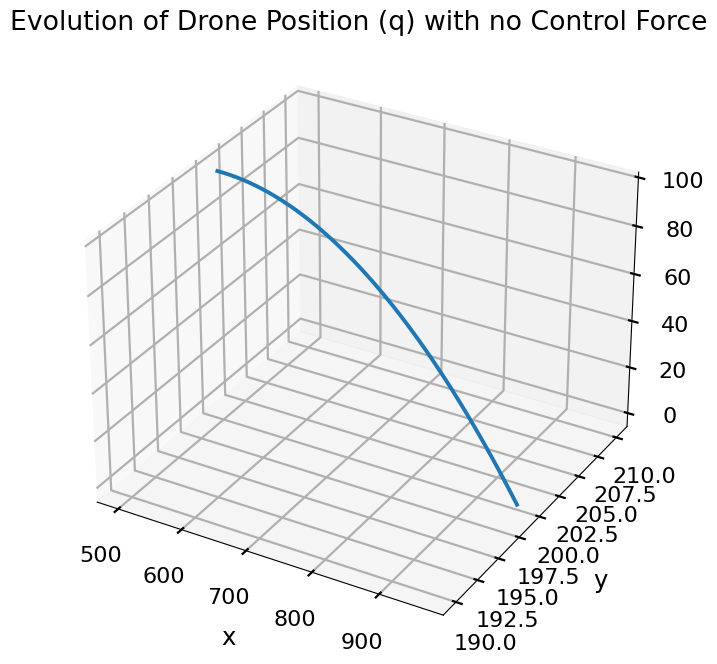

In [ ]:
# plot evolution of drone position q with zero control force
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()

ax.plot3D(qx, qy, qz)
ax.set_title('Evolution of Drone Position (q) with no Control Force')

# set axes labels
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

plt.show()

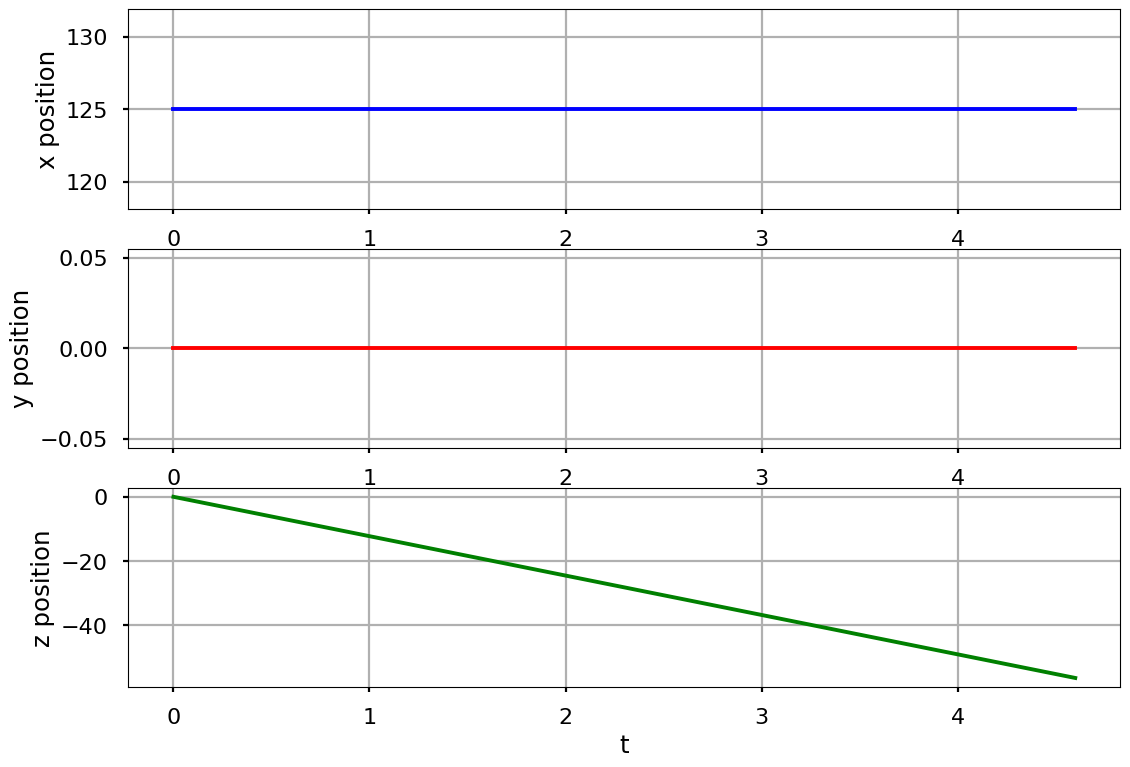

In [ ]:
# plot evolution of drone momentum p with zero control force
fig, ax = plt.subplots(3)

# add time steps correctly

ax[0].plot(T[:47],px, color="blue")
ax[1].plot(T[:47],py, color= "red")
ax[2].plot(T[:47],pz, color= "green")

ax[0].set_xlabel("t");
ax[1].set_xlabel("t");
ax[2].set_xlabel("t");
ax[0].set_ylabel("x position");
ax[1].set_ylabel("y position");
ax[2].set_ylabel("z position");

ax[0].grid()
ax[1].grid()
ax[2].grid()

plt.show()

# Task 3 - Implement a close-loop feedback control force $u$


The "controller" function implements a closed loop feedback control force $u(x,t)$. This control force is calculated by a proportional-derivative (PD) controller. PD control was chosen as it reduces the transient errrors like rise time, overshoot, and oscillations in the output. This included a proportional controller to reduce rise time and as derivative controller  to minimise the transient errors (overshoot and oscillations).  Whilst PD control could amplify the noise, the state is a noiseless signal so the controller does not have this effect and does not require an integral gain to correct time invariant errors.
The controller function also implements conditions for the control force: if $u >50$ , the force is scaled down in by $50N$ in all directions and if $u$ has a negative $z$ component then its $z$ component is set to zero.

A numpy iterator "x_goals" cycles through the different goal positions. Whilst not all goal positions are reached, the controller can land the drone at a safe speed.







In [ ]:
# implement PD controller

# initialise new variables
# goal states (x1, x2, x3)
x1 = np.array([0, 0, 10, 0, 0, 0]) # p = 0 when hovering, no velocity no momentum
x2 = np.array([0, 0, 0.5, 0 , 0 , 0])
x3 = np.array([0, 0, 0, 0 , 0 , 0])
x_goals = [x1, x2, x3]
x_goal_iter = itertools.cycle(x_goals) # numpy iterator

# PD controller gains
Kp = np.array([80, 80, 300]) # 80, 80, 300
Kd = np.array([200, 200, 800]) # 200, 200, 800

def controller(x, x_goal):
    '''
        Function to calculate the closed loop feedback control force
        u(x,t), at each time iteration, to reach a set goal state.
        Uses PD control.
        x = the current state x(t) = (q,p)
        x_goal = the goal state
        Returns the 3d control force u as an array
    '''
    q, p = np.split(x, 2)
    q_goal, p_goal = np.split(x_goal, 2)
    # calculate the error in position q between the current state and the goal state
    error_q = q_goal - q
    # calculate the error in velocity q_dot = p/m between the current state and the goal state
    error_q_dot = p_goal/m - p/m
    # calculate the control force
    u = (Kp * error_q) + (Kd * error_q_dot)

    # conditions for the control force
    while np.linalg.norm(u) > 50:
      u = (u/np.linalg.norm(u))*50
    # check u has a non-negative upwards component
    if u[2] < 0:
      u[2] = 0
    return u

In [ ]:
# numerical solver - RK4
def solve_ivp_rk4(f, x0, T):
      count = 0
      X = [None for ti in T]
      X[0] = x0
      x_goal = next(x_goal_iter)
      still_time = 0

      for i in range(len(T))[1:]:
        # check if position matches a goal state x_goal
        # if true for:
        # - x1: wait ten seconds (100 iterations) then change to x2
        # - x2: wait two seconds then change to x3
        # - x3: break
        x_current = X[i - 1]
        if np.all(x_current < (x_goal + 1)) and np.all(x_current > (x_goal - 1)): # 40cm tolerance
          still_time += 1
          if still_time == 1000 and x_goal == x1:
            x_goal = next(x_goal_iter)
            print(x_goal)# print reached this goal
            still_time = 0
          if still_time == 100 and (x_goal == x2): # can remove
            x_goal = next(x_goal_iter) # set the x3
            print(x_goal)# print reached this goal
            still_time = 0

        Delta_t = T[i] - T[i - 1]
        # runge kutta formulae
        k1 = Delta_t * f(T[i - 1], X[i - 1],x_goal)
        k2 = Delta_t * f(T[i - 1] + 0.5 * Delta_t, X[i - 1] + 0.5 * k1,x_goal)
        k3 = Delta_t * f(T[i - 1]+ 0.5 * Delta_t, X[i - 1] + 0.5 * k2,x_goal)
        k4 = Delta_t * f(T[i - 1] + Delta_t, X[i - 1] + k3,x_goal)
        # Update next value of X
        X[i] = X[i - 1] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)

        # crash detector
        # qz = heights (positions in the z direction)
        qz = X[i][2]
        # if qz is negative
        if qz <= 0:
          land_time = T[i]
          px = X[i][3]
          py = X[i][4]
          pz = X[i][5]
          print(f"time to land = {land_time}")
          land_speed = np.sqrt((px/m)**2+(py/m)**2+(pz/m)**2) # speed calculated as the magnitude of the velocities in xyz directions
          if land_speed >= 4:
            print(f"crash landing at speed {land_speed}")
            break
          else:
            print(f"safe landing at speed {land_speed}")
            break

      return T, X

# ode model x(t) = (q,p)
# unlike task 2, in task 3 we also pass in a control force u from the controller function
def ode_f(t, x, x_goal):
  q, p = np.split(x, 2)
  q_dot = p/m
  # run control function to get the u output forces for x_goal
  u = controller(x, x_goal)
  # print(u)# remove!
  p_dot = np.array(u -  m*g)
  x_dot = np.concatenate((q_dot, p_dot))
  return x_dot

In [ ]:
# numerical solver solution again but with control force
T, X_rk4 = solve_ivp_rk4(ode_f, x0, T)

# removing the empty values below gound level qz = 0 (after the drone has landed/crashed)
X_rk4 = [i for i in X_rk4 if i is not None]

# postion (q) values
qx = [val[0] for val in X_rk4]
qy = [val[1] for val in X_rk4]
qz = [val[2] for val in X_rk4]
# momentum (p) values
px = [val[3] for val in X_rk4]
py = [val[4] for val in X_rk4]
pz = [val[5] for val in X_rk4]


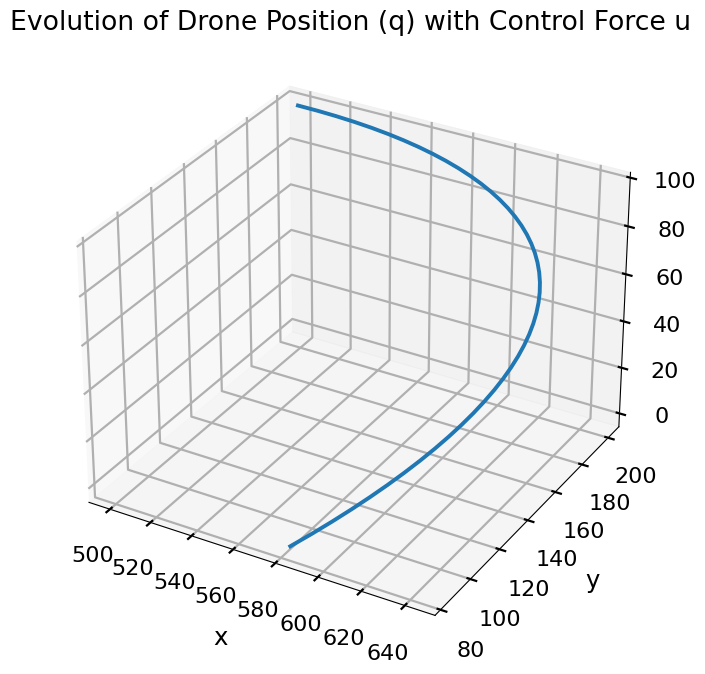

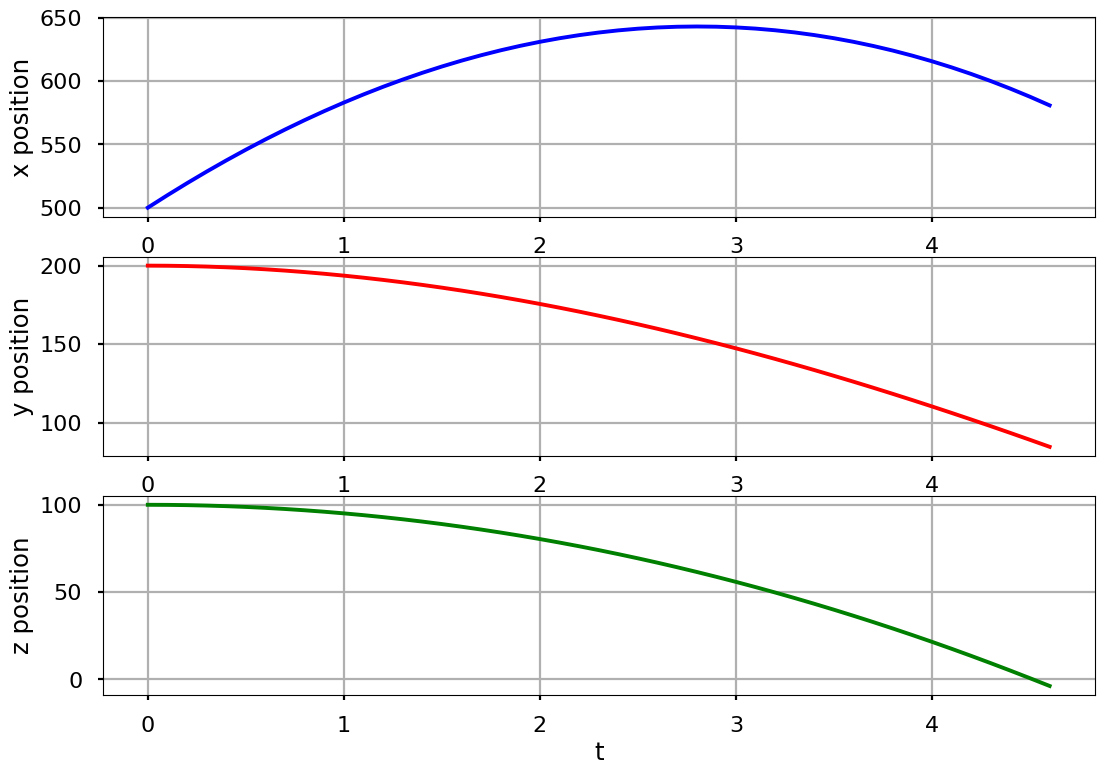

In [ ]:
# 3D plot of the evolution of drone position q with control force u
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()

ax.plot3D(qx, qy, qz)
ax.set_title('Evolution of Drone Position (q) with Control Force u')

# set axes labels
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

plt.show()

# 2d plots of the evolution of the drone to confirm success of the control scheme
fig, ax = plt.subplots(3)

ax[0].plot(T[:47],qx, color="blue")
ax[1].plot(T[:47],qy, color= "red")
ax[2].plot(T[:47],qz, color= "green")

ax[0].set_xlabel("t");
ax[1].set_xlabel("t");
ax[2].set_xlabel("t");
ax[0].set_ylabel("x position");
ax[1].set_ylabel("y position");
ax[2].set_ylabel("z position");

ax[0].grid()
ax[1].grid()
ax[2].grid()

plt.show()

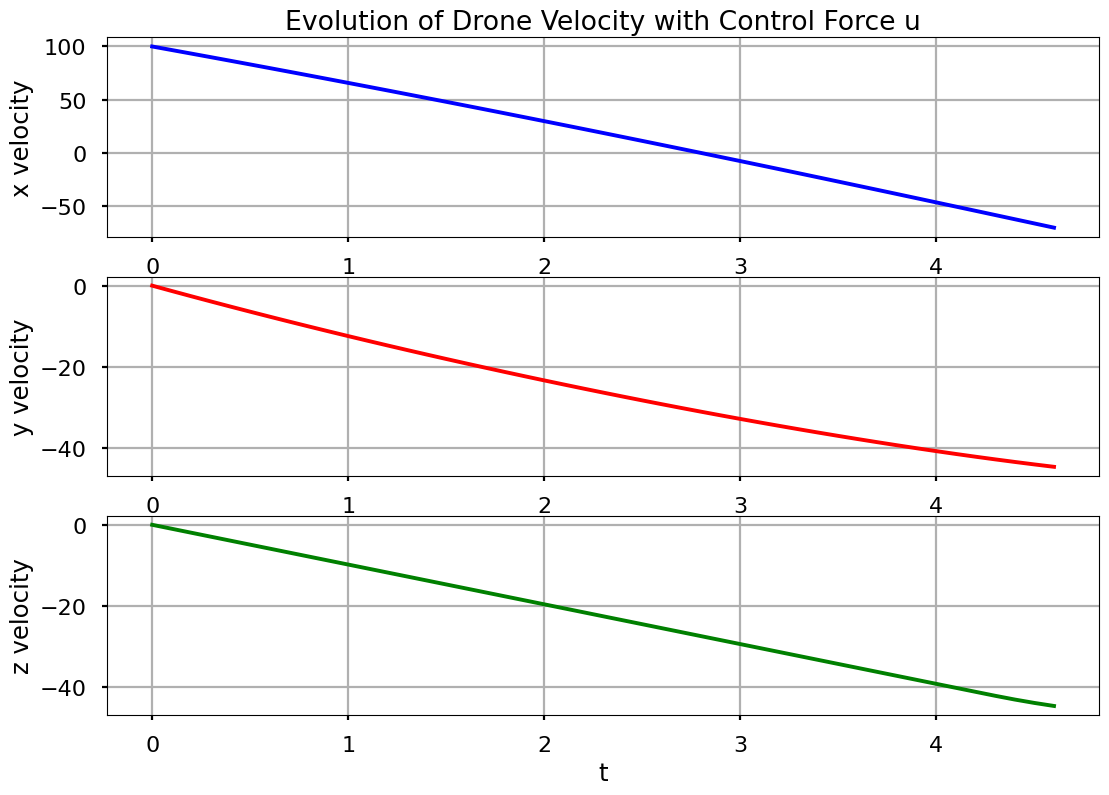

In [ ]:
# plot evolution of drone momentum p with control force u
fig, ax = plt.subplots(3)

ax[0].plot(T[:47],px/m, color="blue")
ax[1].plot(T[:47],py/m, color= "red")
ax[2].plot(T[:47],pz/m, color= "green")

ax[0].set_xlabel("t");
ax[1].set_xlabel("t");
ax[2].set_xlabel("t");
ax[0].set_ylabel("x velocity");
ax[1].set_ylabel("y velocity");
ax[2].set_ylabel("z velocity");
ax[0].set_title('Evolution of Drone Velocity with Control Force u')


ax[0].grid()
ax[1].grid()
ax[2].grid()

plt.show()